In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
import datetime

In [ ]:
#Load Dataset
df = pd.read_csv('san-juan_dataset.csv')

#Extract Temporal Features
df['datetime_committed'] = pd.to_datetime(df['datetime_committed'])

#New column for month period
df['month'] = df['datetime_committed'].dt.to_period('M')

#Group by barangay monthly
crime_by_barangay_monthly = df.groupby(['barangay', 'month']).size().unstack(fill_value=0)

#Group by month and count number of crimes per month
crime_per_month = df.groupby('month').size()

# Convert the period index to timestamp for easier plotting and analysis
crime_per_month.index = crime_per_month.index.to_timestamp()

In [ ]:
# Apply first differencing
crime_per_month_diff = crime_per_month.diff().dropna()

# Perform the ADF test again on the differenced series
result_diff = adfuller(crime_per_month_diff)

print("ADF Statistic (Differenced):", result_diff[0])
print("p-value (Differenced):", result_diff[1])

# Interpret the result
if result_diff[1] <= 0.05:
    print("\nThe differenced series is stationary (reject the null hypothesis).")
else:
    print("\nThe differenced series is still non-stationary (fail to reject the null hypothesis).")


ADF Statistic (Differenced): -9.449180118150828
p-value (Differenced): 4.666216703719806e-16

The differenced series is stationary (reject the null hypothesis).


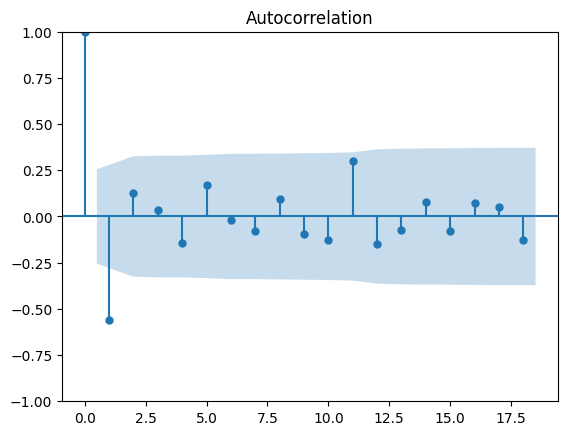

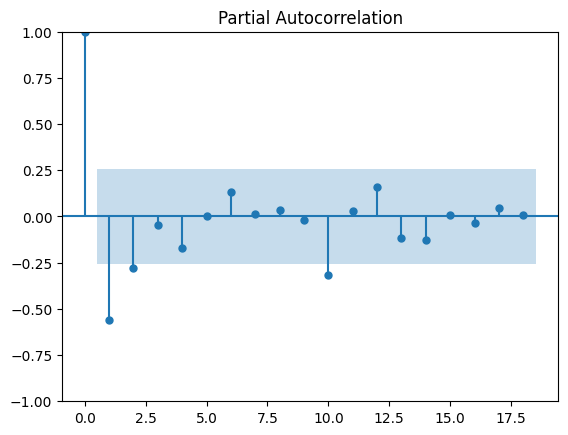

In [ ]:
#ACF and PACF plot
acf = plot_acf(crime_per_month_diff)

plt.show()
pacf = plot_pacf(crime_per_month_diff)

In [ ]:
# 80% for training, 20% for testing
train_size = int(len(crime_per_month) * 0.8)
train, test = crime_per_month[:train_size], crime_per_month[train_size:]

#Model Fit (1,1,1)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()
print(f'Model Fit Summary')
print(model_fit.summary())

Model Fit Summary
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   48
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -160.396
Date:                Mon, 03 Feb 2025   AIC                            326.791
Time:                        11:32:06   BIC                            332.341
Sample:                    01-01-2019   HQIC                           328.880
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2847      0.170     -1.673      0.094      -0.618       0.049
ma.L1         -0.6786      0.162     -4.191      0.000      -0.996      -0.361
sigma2        52.7202     11.153  

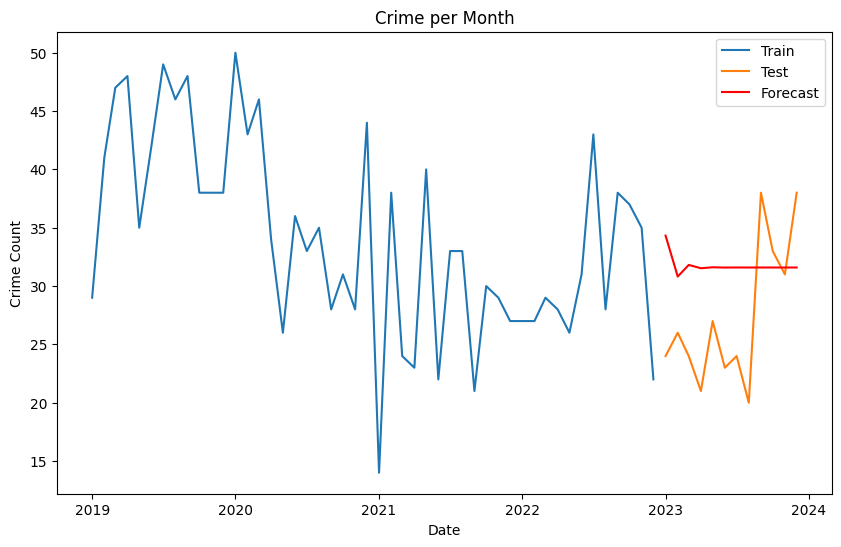

Mean Absolute Error (MAE): 6.722329915564191
Mean Squared Error (MSE): 56.079004418385864
Root Mean Squared Error (RMSE): 7.48859161781345
San Juan Overall - Forecasted values (average crimes per month): 2023-01-01    34.320821
2023-02-01    30.813158
2023-03-01    31.811768
2023-04-01    31.527470
2023-05-01    31.608408
2023-06-01    31.585366
2023-07-01    31.591926
2023-08-01    31.590058
2023-09-01    31.590590
2023-10-01    31.590438
2023-11-01    31.590481
2023-12-01    31.590469
Freq: MS, Name: predicted_mean, dtype: float64



In [ ]:
#Plot the forecast
forecast = model_fit.forecast(len(test)) #len(test)
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('Crime per Month')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.legend()
plt.show()

mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f"San Juan Overall - Forecasted values (average crimes per month): {forecast}\n")

Processing barangay: ADDITION HILLS


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


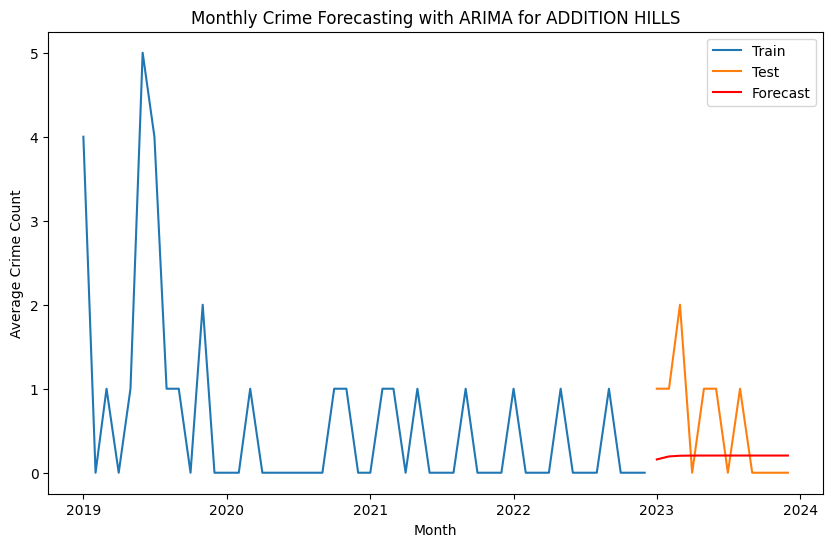

Processing barangay: BALONG-BATO


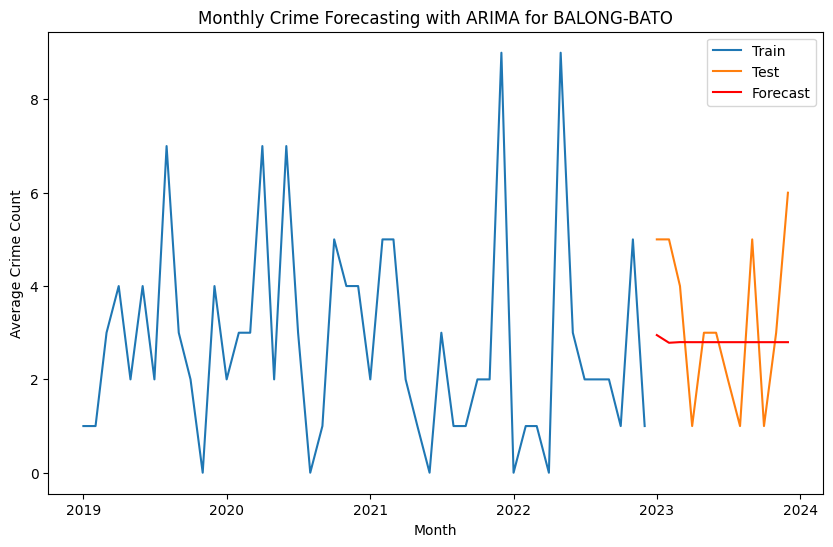

Processing barangay: BATIS


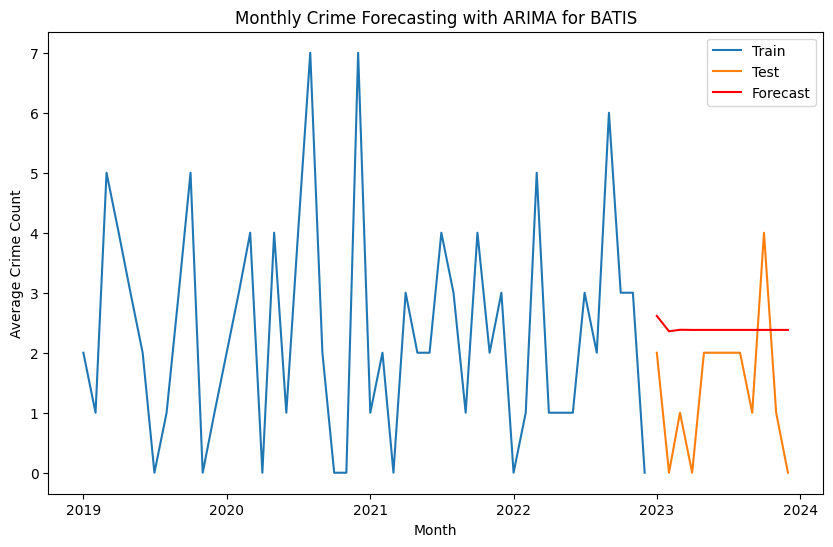

Processing barangay: CORAZON DE JESUS


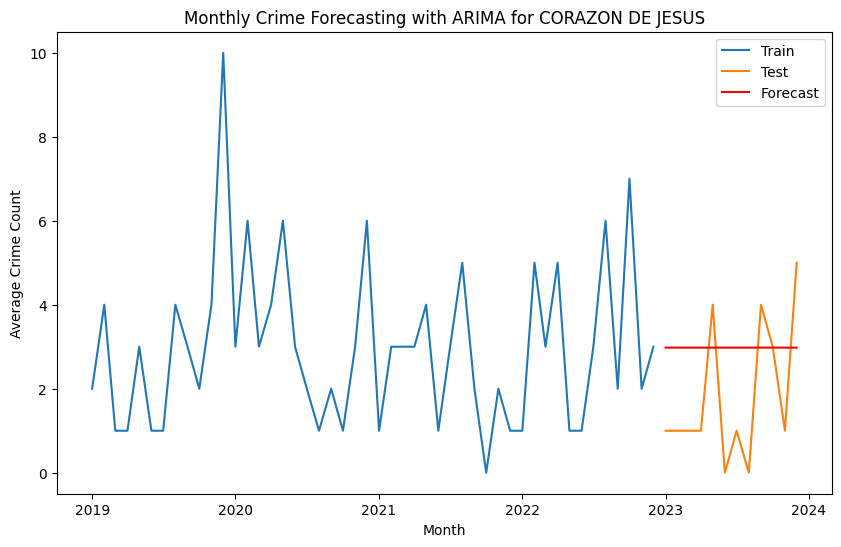

Processing barangay: ERMITAñO


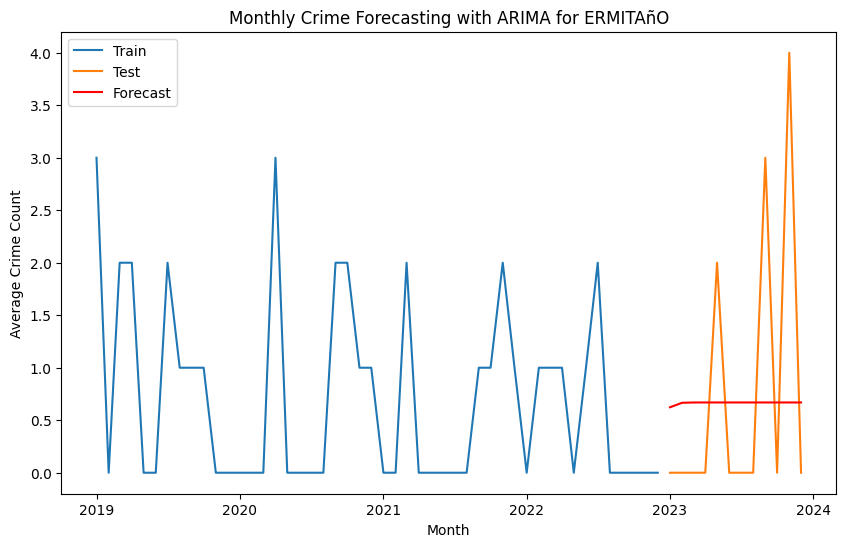

Processing barangay: GREENHILLS


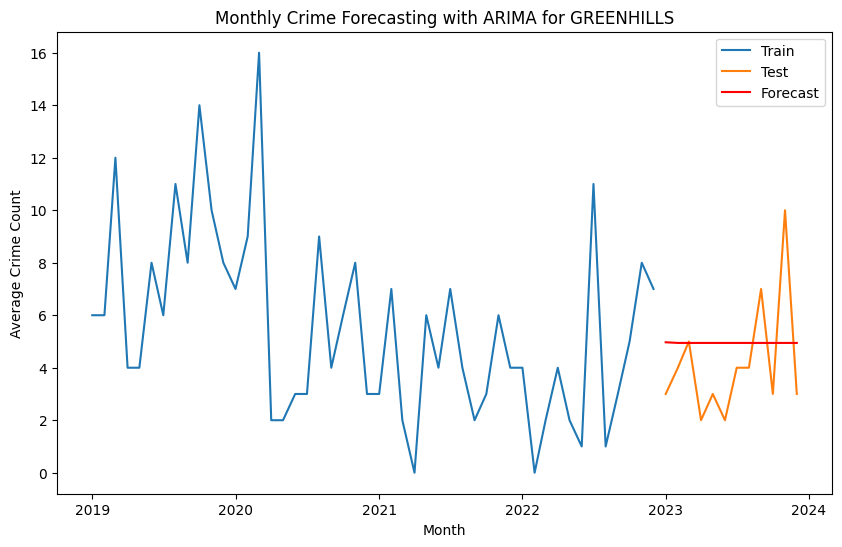

Processing barangay: HALO-HALO (ST. JOSEPH)


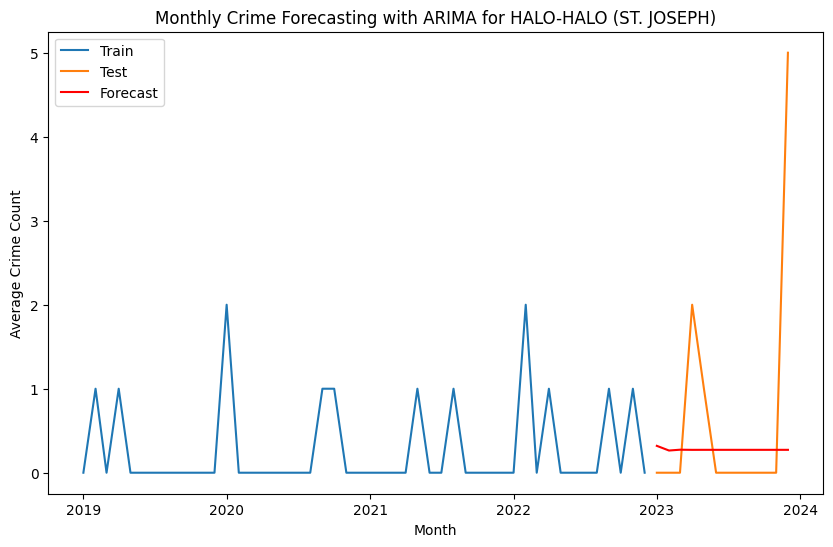

Processing barangay: ISABELITA


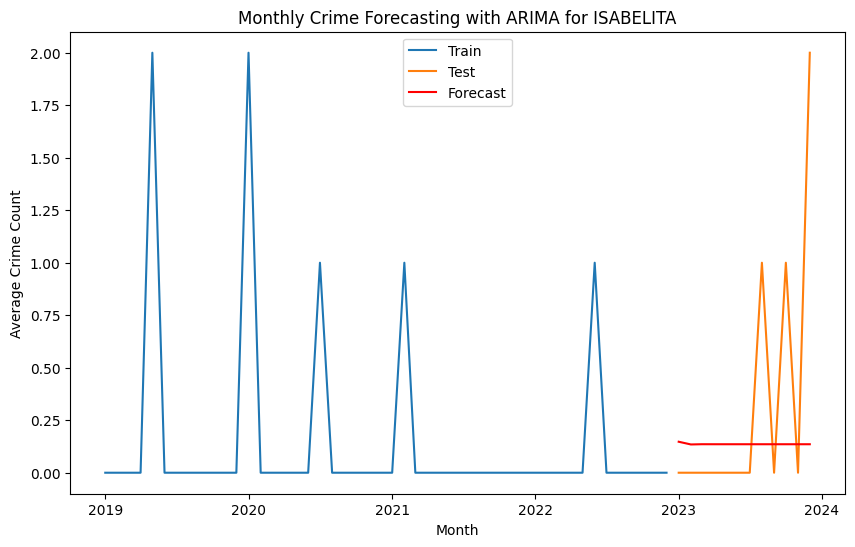

Processing barangay: KABAYANAN


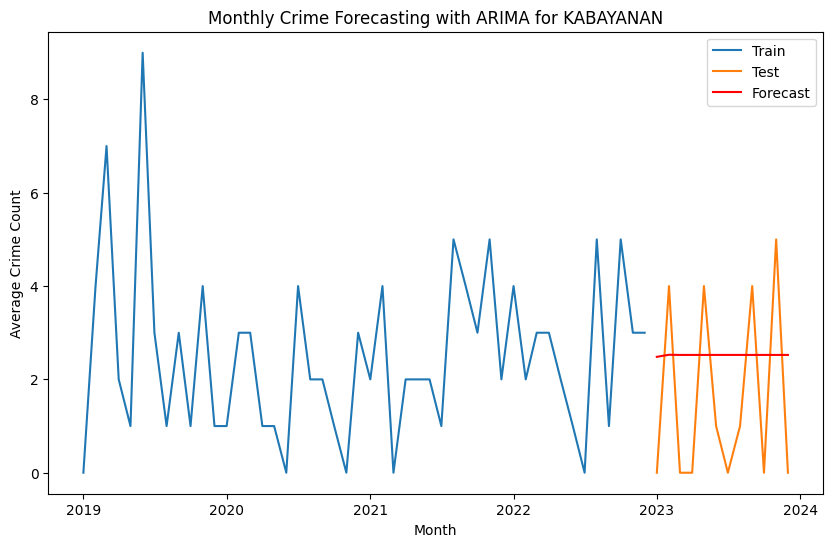

Processing barangay: LITTLE BAGUIO


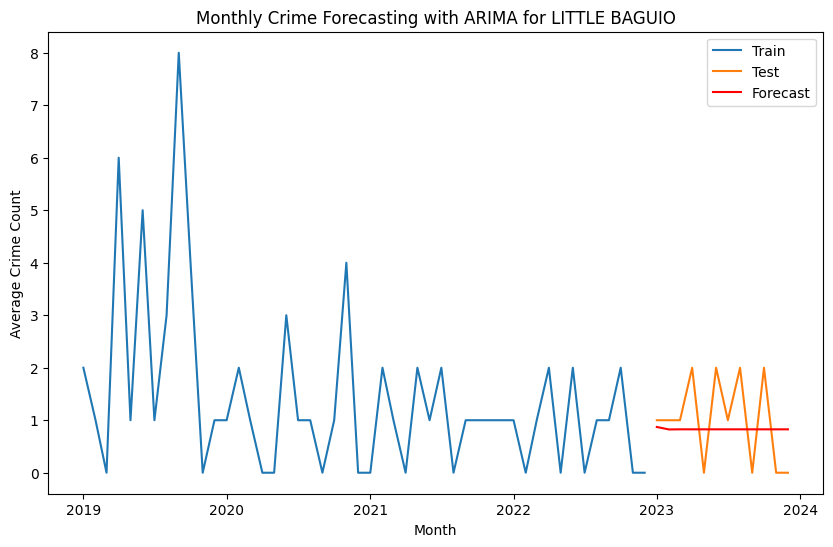

Processing barangay: MAYTUNAS


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


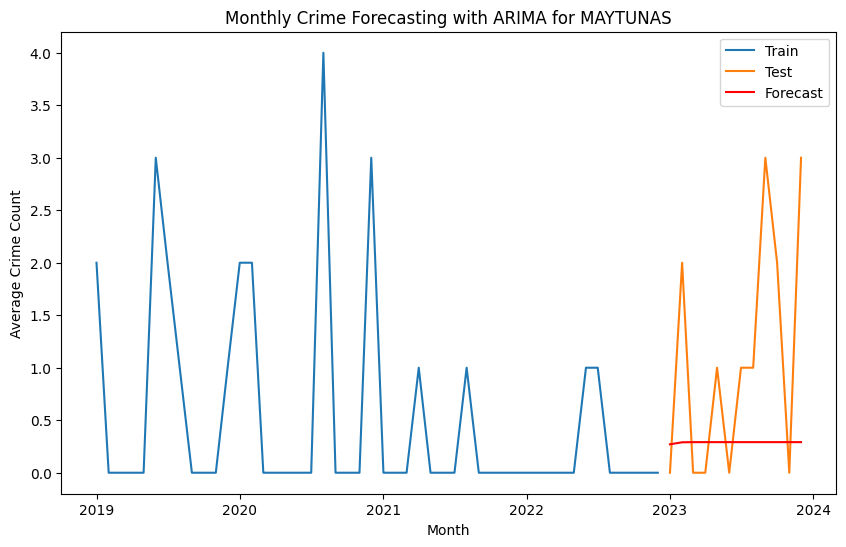

Processing barangay: ONSE


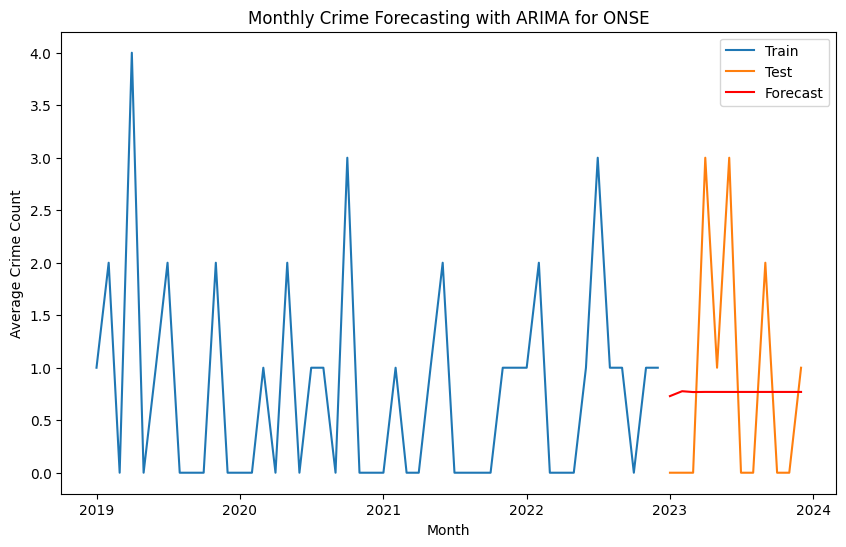

Processing barangay: PASADEñA


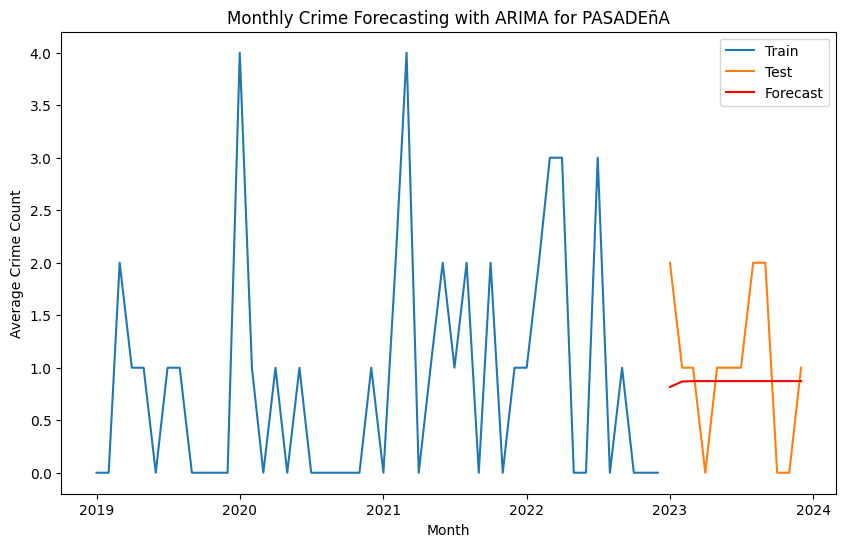

Processing barangay: PEDRO CRUZ


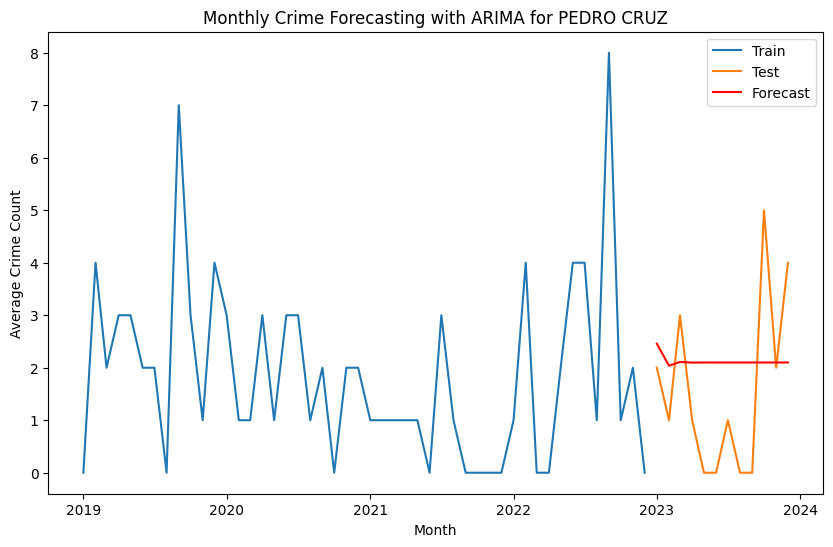

Processing barangay: PROGRESO


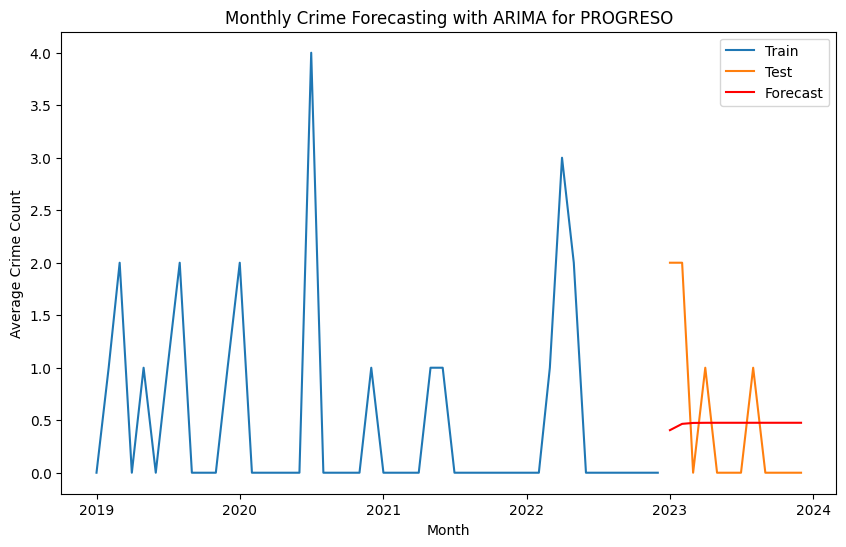

Processing barangay: RIVERA


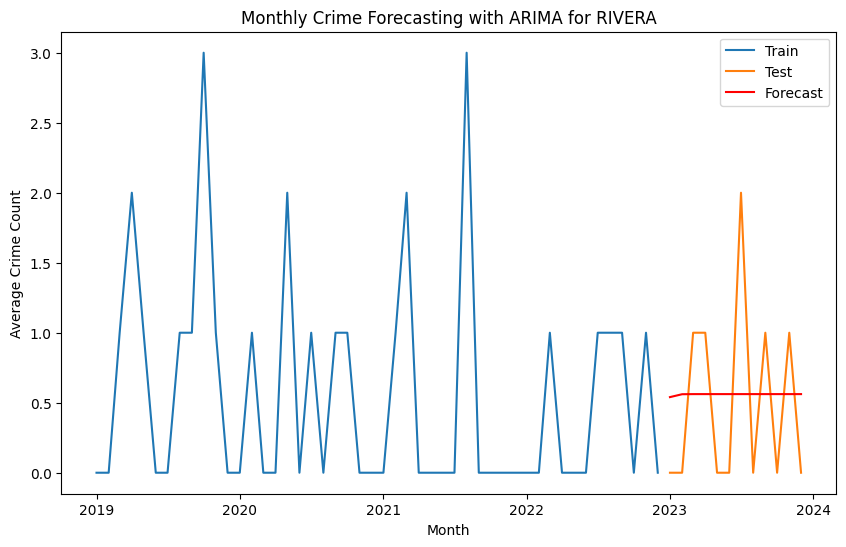

Processing barangay: SALAPAN


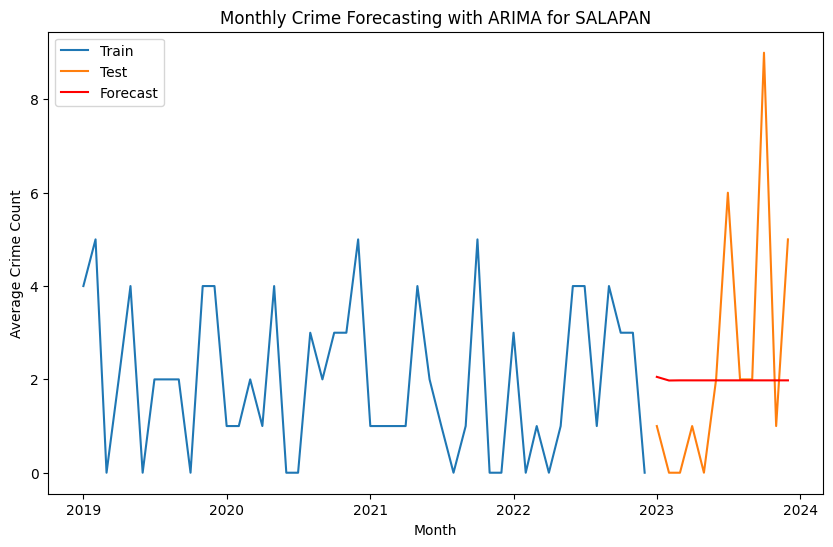

Processing barangay: SAN PERFECTO


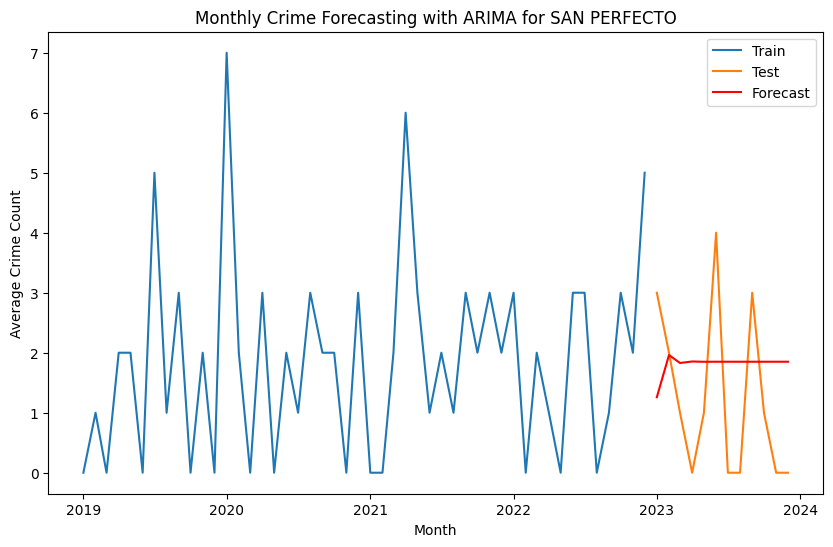

Processing barangay: SANTA LUCIA


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


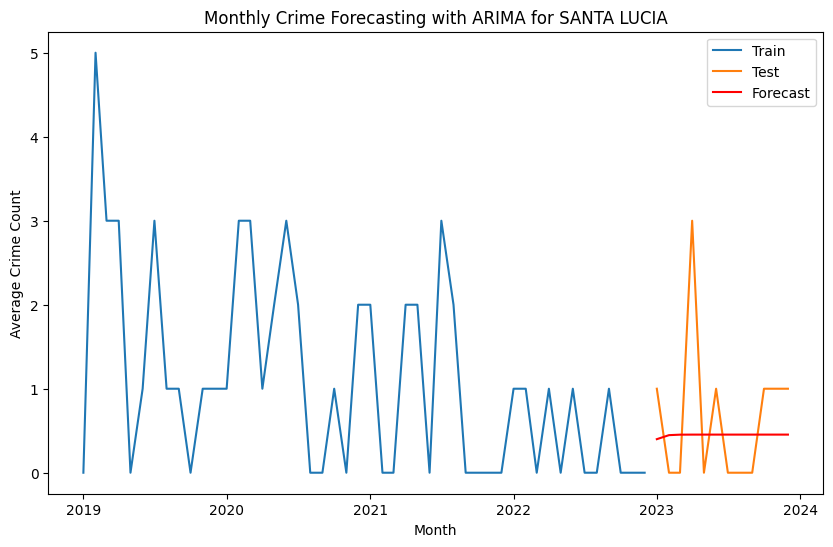

Processing barangay: TIBAGAN


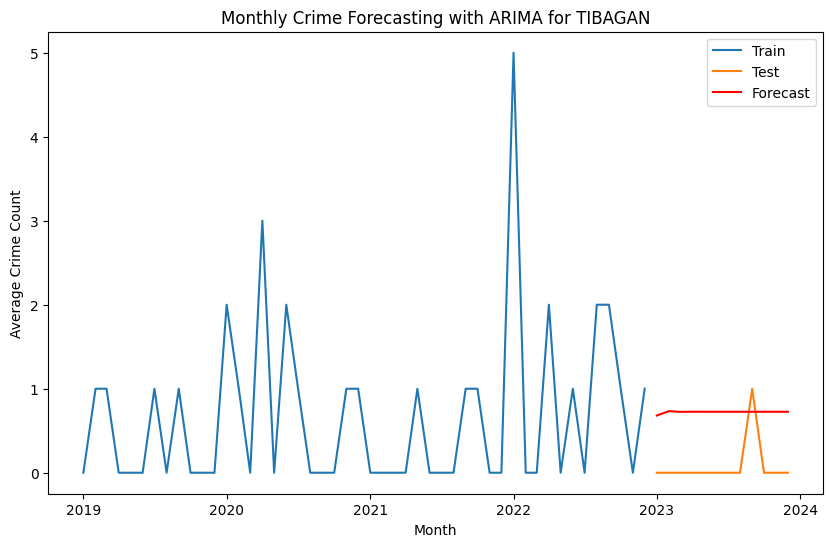

Processing barangay: WEST CRAME


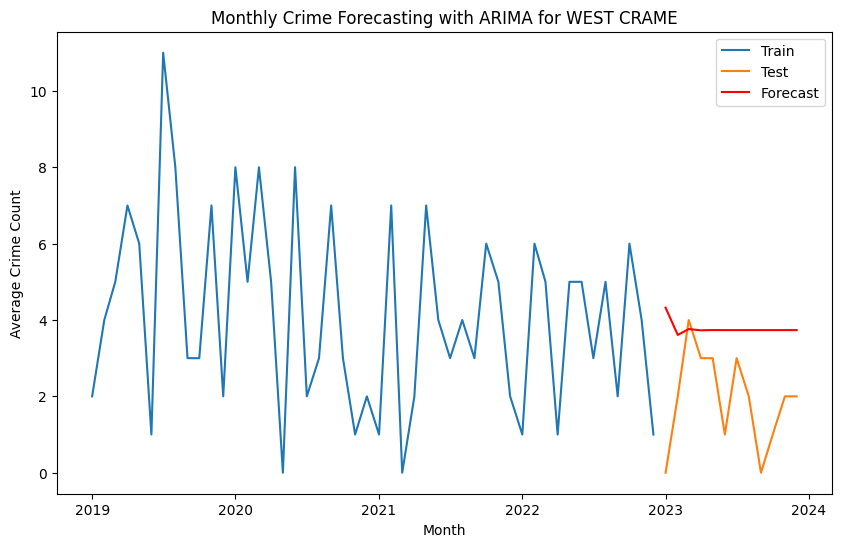

In [ ]:
# Forecasting for each barangay
barangay_monthly_forecasts = {}

for barangay in crime_by_barangay_monthly.index:
    print(f"Processing barangay: {barangay}")

    # Get the time series data for the barangay
    crime_series = crime_by_barangay_monthly.loc[barangay]

    # Split into training and testing
    train_size = int(len(crime_series) * 0.8)
    train, test = crime_series[:train_size], crime_series[train_size:]

    # Convert PeriodIndex to Timestamp for compatibility with plotting
    train.index = train.index.to_timestamp()
    test.index = test.index.to_timestamp()

    # Fit the ARIMA model
    model = ARIMA(train, order=(1, 1, 1))  # Modify (p, d, q) as needed
    model_fit = model.fit()

    # Forecast the test period
    forecast = model_fit.forecast(len(test))

    # Store the results
    barangay_monthly_forecasts[barangay] = {
        'forecast': forecast,
        'test': test,
        'mae': mean_absolute_error(test, forecast),
        'mse': mean_squared_error(test, forecast),
        'rmse': np.sqrt(mean_squared_error(test, forecast))
    }

    # Plot the results for each barangay
    plt.figure(figsize=(10, 6))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(test.index, forecast, label='Forecast', color='red')
    plt.title(f'Monthly Crime Forecasting with ARIMA for {barangay}')
    plt.xlabel('Month')
    plt.ylabel('Average Crime Count')
    plt.legend()
    plt.show()



In [ ]:
# Display the forecast results for each barangay
for barangay, metrics in barangay_monthly_forecasts.items():
    print(f"Barangay: {barangay}")
    print(f"Mean Absolute Error (MAE): {metrics['mae']}")
    print(f"Mean Squared Error (MSE): {metrics['mse']}")
    print(f"Root Mean Squared Error (RMSE): {metrics['rmse']}")
    print(f"Forecasted values (average crimes per month): {metrics['forecast']}\n")

Barangay: ADDITION HILLS
Mean Absolute Error (MAE): 0.5882206288688409
Mean Squared Error (MSE): 0.5615935151642825
Root Mean Squared Error (RMSE): 0.749395433108771
Forecasted values (average crimes per month): 2023-01-01    0.158340
2023-02-01    0.194122
2023-03-01    0.202209
2023-04-01    0.204036
2023-05-01    0.204449
2023-06-01    0.204542
2023-07-01    0.204564
2023-08-01    0.204568
2023-09-01    0.204569
2023-10-01    0.204570
2023-11-01    0.204570
2023-12-01    0.204570
Freq: MS, Name: predicted_mean, dtype: float64

Barangay: BALONG-BATO
Mean Absolute Error (MAE): 1.472466250094879
Mean Squared Error (MSE): 3.00951677926297
Root Mean Squared Error (RMSE): 1.734795889798846
Forecasted values (average crimes per month): 2023-01-01    2.949562
2023-02-01    2.784643
2023-03-01    2.798594
2023-04-01    2.797414
2023-05-01    2.797514
2023-06-01    2.797506
2023-07-01    2.797506
2023-08-01    2.797506
2023-09-01    2.797506
2023-10-01    2.797506
2023-11-01    2.797506
2023-